In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import warnings

pd.set_option("display.max_columns", None)
df_data_0 = pd.read_excel('2019-spring-match-data-OraclesElixir-2019-05-21.xlsx')
df_data_1 = pd.read_excel('2019-summer-match-data-OraclesElixir-2019-09-16.xlsx')

warnings.filterwarnings('ignore')

Checking the data. Since the data from LPL(region from China) is not complete. Therefore, to make the kernel inherent, I decided to drop the rows from LPL.

In [2]:
df_data_0.drop(df_data_0[df_data_0['league'] == 'LPL'].index, inplace = True)
df_data_1.drop(df_data_1[df_data_1['league'] == 'LPL'].index, inplace = True)
df_data_0.drop(df_data_0[df_data_0['league'] == 'MSI'].index, inplace = True)


data = pd.concat([df_data_0, df_data_1])

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
init_notebook_mode(connected=True) 

# Data Extraction & Loading

In [3]:
print(data.shape)
print ('there are total {} games in season 2019'.format(len(data.gameid.unique())))


(16920, 98)
there are total 1404 games in season 2019


In [4]:
data.columns

Index(['gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno',
       'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1',
       'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas',
       'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd',
       'fdtime', 'teamdragkills', 'oppdragkills', 'elementals',
       'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes',
       'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft',
       'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
       'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'visiblewardclearrate',
       'invisiblewardclearrate', 'totalgold', 'earnedg

To investigate the on how to make accurate prediction on the outcome of a League of Legend professional game at different times. We looked at information available at different time point: pre-match and 10-minute benchmark. Specifically, we compare between players with same roles on different team, and use the difference statistics as features.


First blood, First tower and First dragon are important to predict in early game. But some rows are NaN. Therefore, I will suppose those rows with NaN as not token(0).

In [5]:
data['fb'] = data.apply(lambda x: 1 if x.fb == 1 else 0, axis=1)
data['ft'] = data.apply(lambda x: 1 if x.fb == 1 else 0, axis=1)
data['fd'] = data.apply(lambda x: 1 if x.fb == 1 else 0, axis=1)

# Initial Data Exploration

In [6]:
team_data = data.groupby('team').mean().reset_index().sort_values('result', ascending = False)

The side which first-picks a champion is the blue team, and the other is the red team. Since game result is hugely influenced by the champion Ban-Pick, and the ‘geography’ of map will also influence teams to snatch map resource, the win rate of red and blue side is different.

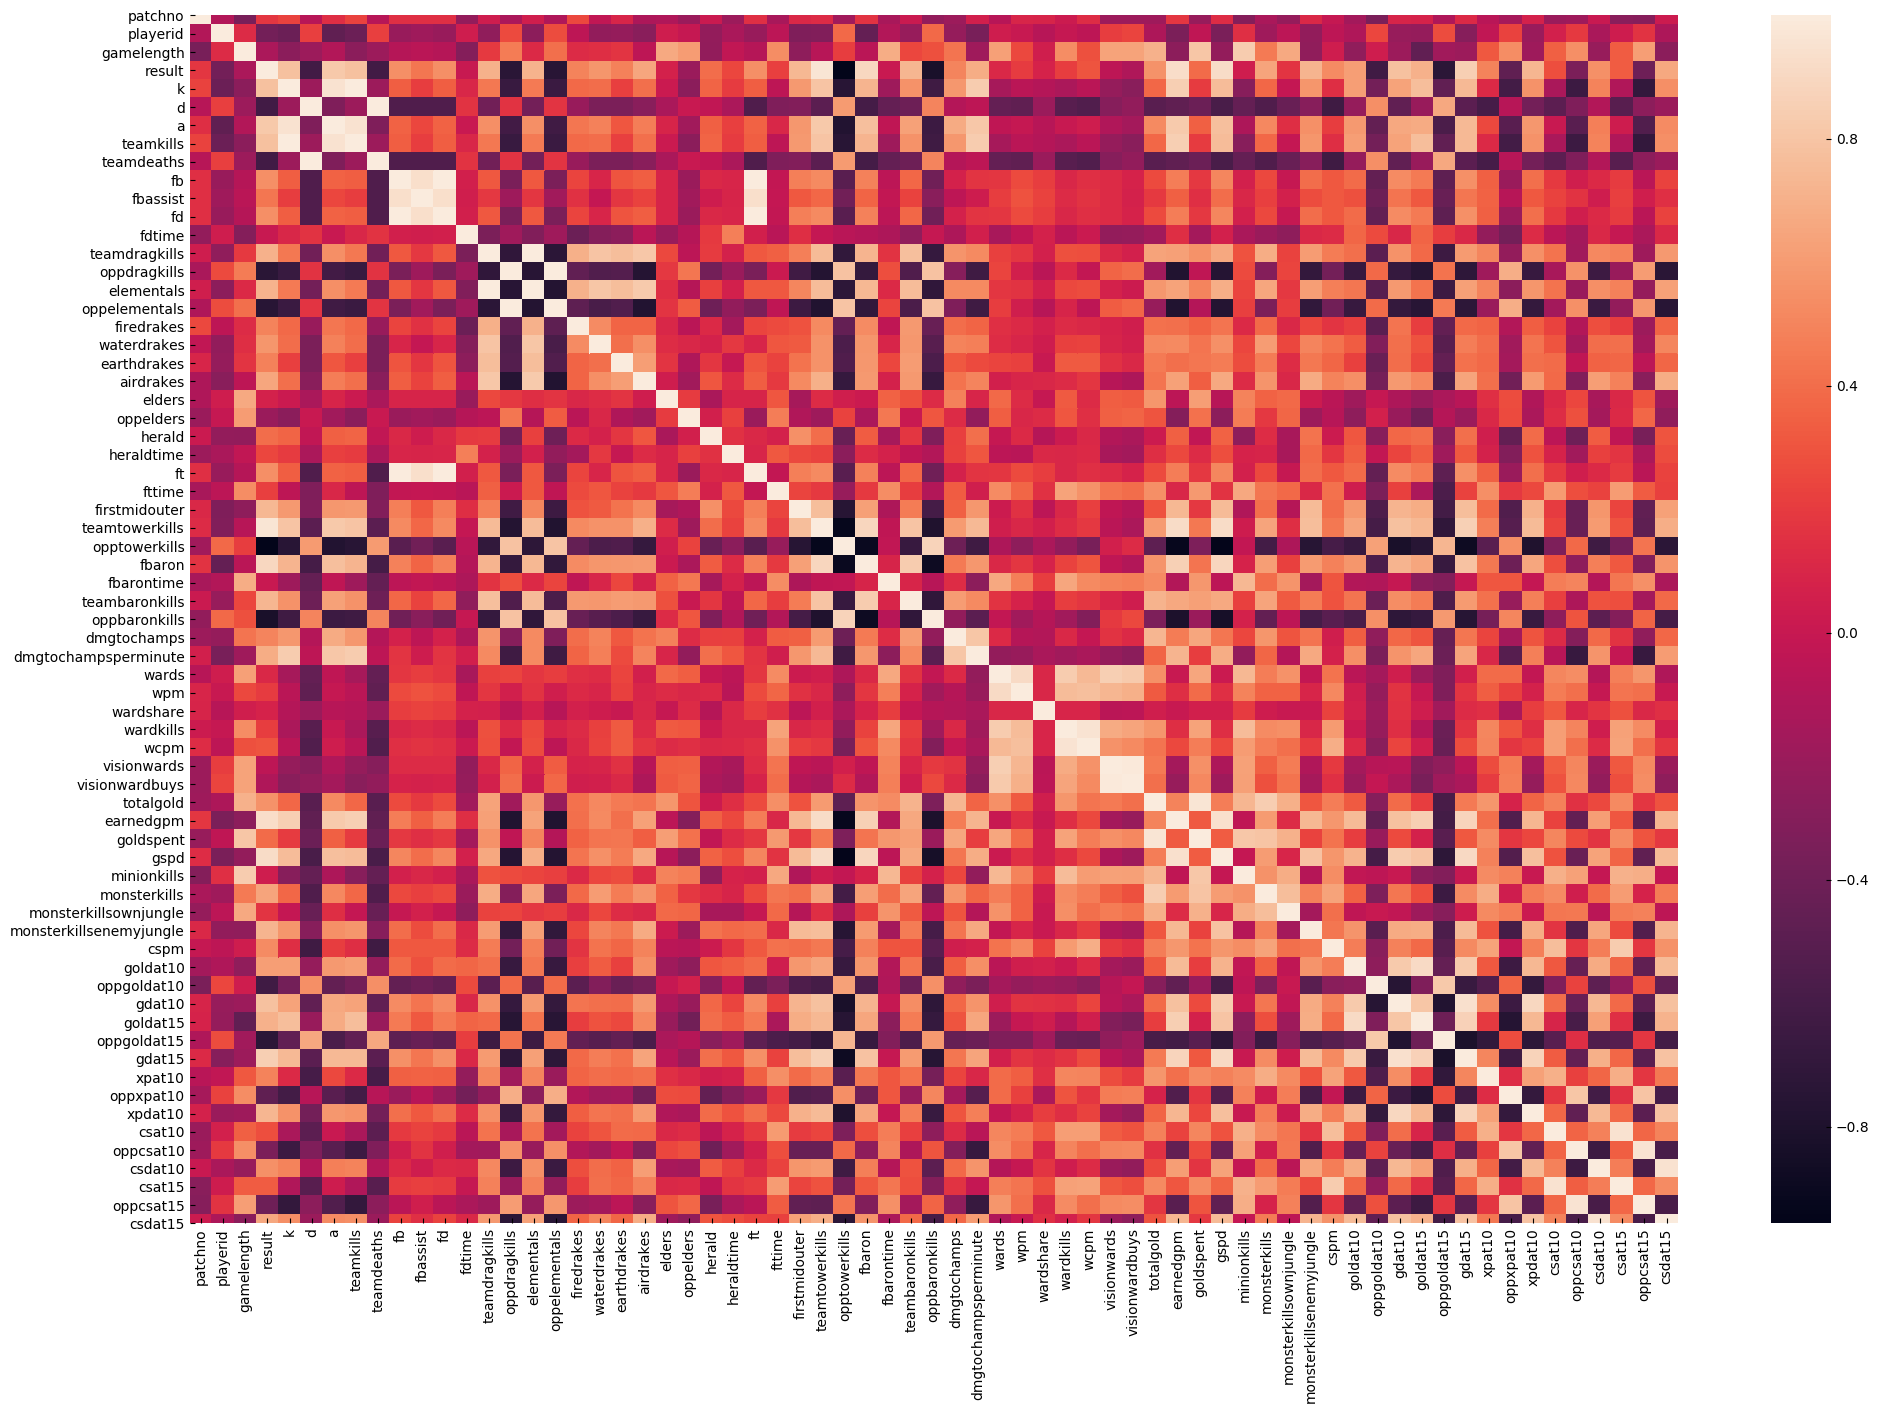

In [7]:
team_corr = team_data
if 'gameid' in team_corr.columns.tolist():
    # doubles/triples/quadras/pentas/okpm are not important for prediction. 
    # elementals, airdrakes, ... are chosen with randomness so they're not significant
    # heraldtime barontime will not spawing at early time
    # time var : make no sense in corr
    team_corr = players_corr.drop(['patchno','doubles','triples','quadras','pentas','gameid','playerid','firedrakes','elders','elementals','waterdrakes','earthdrakes','airdrakes','heraldtime','fbarontime','okpm', 'fttime', 'gamelength'], axis=1)

corr = team_corr.corr()
f, ax = plt.subplots(figsize=(24, 16))
heatmap = sns.heatmap(corr)

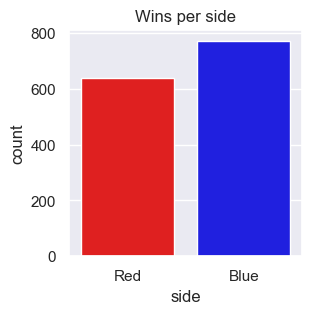

In [8]:
sns.set(rc={'figure.figsize':(3,3)})
games = data[data['player'] == 'Team']
games_win = games[games['result'] == 1]
games_lose = games[games['result'] == 0]
graph_data = pd.concat([games['side'], games['result']], axis=1)
sns.countplot(graph_data[graph_data.result == 1]['side'], palette=['red','blue'])
plt.title('Wins per side')
plt.show()

Beside the sides of game, the most attribute influenced the the prediction at pre_match is the history result of team. For a specific region, some teams are always win, and others' results are not satisfying.

My work is to make the pre-match prediction is based on other attributes, making our prediction more accurate than only based on history win_rate, which means my work is not nonsense.

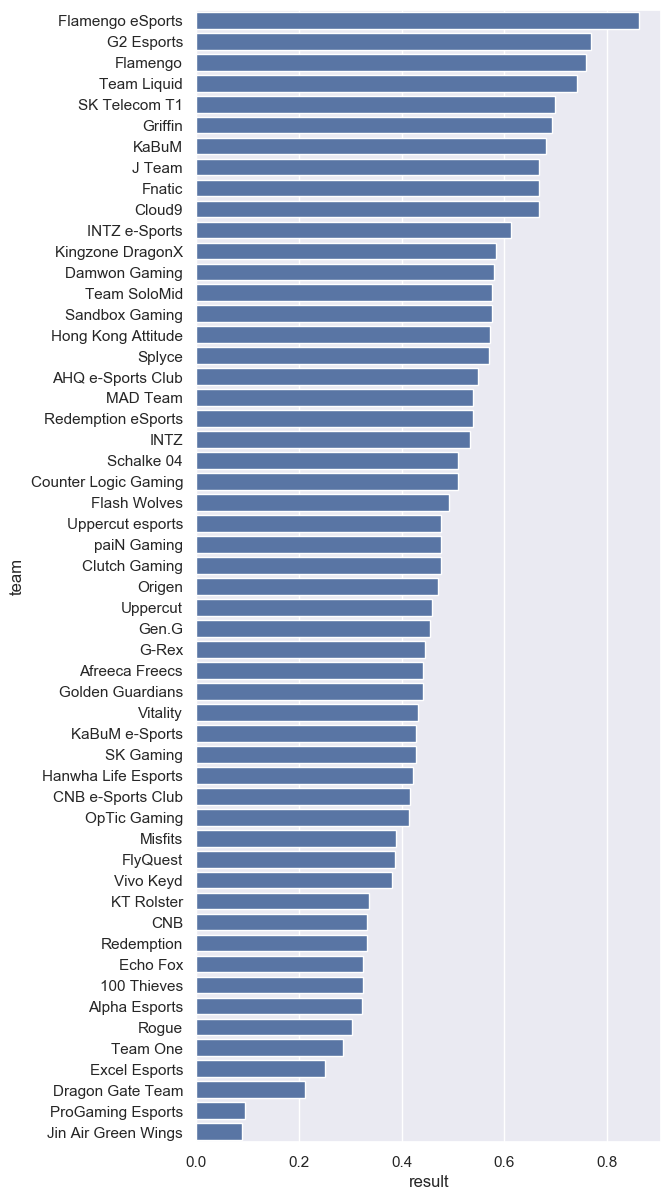

In [9]:
plt.subplots(figsize=(6, 15))

sns.barplot(y="team", x="result", data=team_data,
            label="Win_result", color="b")

Besides the team history win_rate, the champions selected is another attribute to influence the prediction

In [10]:
champion_data = data.groupby('champion').mean().reset_index().sort_values('result',ascending = False)
champion_data1  = data.groupby(['player','champion']).mean().reset_index().sort_values('result',ascending = False)
temp = data[data.player != 'Team']
temp['c_r'] = None
temp['t_r'] = None
temp['p_c_r'] = None
for i in temp.player.unique():
    cl = temp[temp.player == i].champion.unique()
    for j in cl:
        temp.loc[(temp.champion == j),['c_r']] = champion_data[champion_data.champion == j].result.values[0] 
        temp.loc[(temp.champion == j)&(temp.player == i),['p_c_r']] = champion_data1[(champion_data1.champion == j)&(champion_data1.player == i)].result.values[0] 
for i in temp.team.unique():
    temp.loc[temp.team == i,['t_r']] = team_data[team_data.team == i].result.values[0]


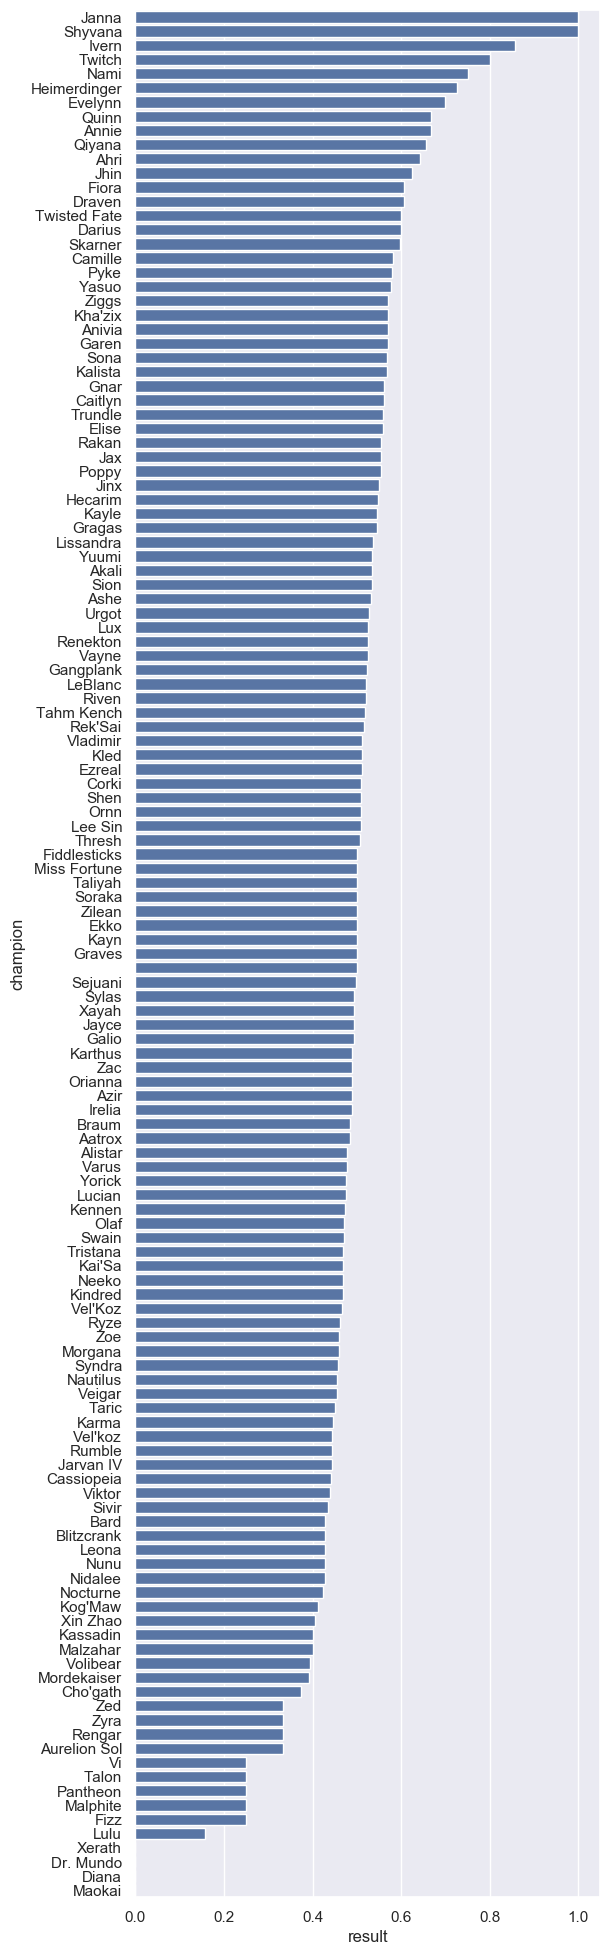

In [11]:
plt.subplots(figsize=(6, 25))
sns.barplot(y="champion", x="result", data=champion_data,
            label="Win_result", color="b")

As you can see, some champion has higher win rate. That is because Riot did update all the time. A small patch to adjust the attributes of champion will lead to out balence. 

The team picked better champion will significant influence the chance to win the game. 

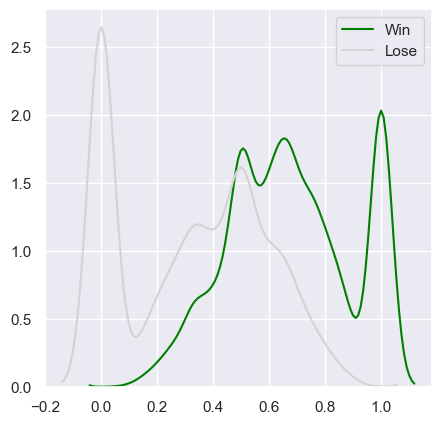

In [12]:
a = temp[temp.result == 1].rename(columns={'p_c_r':'Win'})
b = temp[temp.result == 0].rename(columns={'p_c_r':'Lose'})
plt.subplots(figsize=(5, 5))
sns.kdeplot(a['Win'],color = 'green')
sns.kdeplot(b['Lose'],color = 'lightgray')

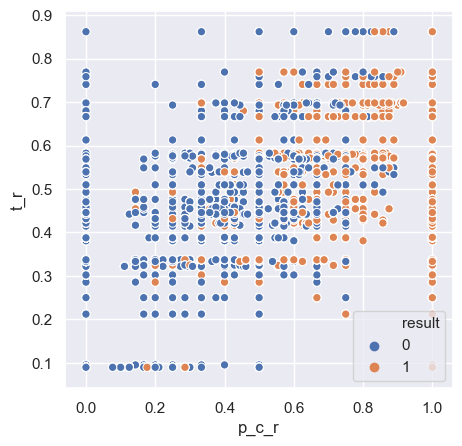

In [13]:
plt.subplots(figsize=(5, 5))
sns.scatterplot(x = 'p_c_r', y = 't_r', hue = 'result', data = temp)

Picked 4 champion with different win rate(Kalista > Gragas > 0.5 > Sivir > Xin Zhao), the played time are all larger than 100. let's check their chance to win

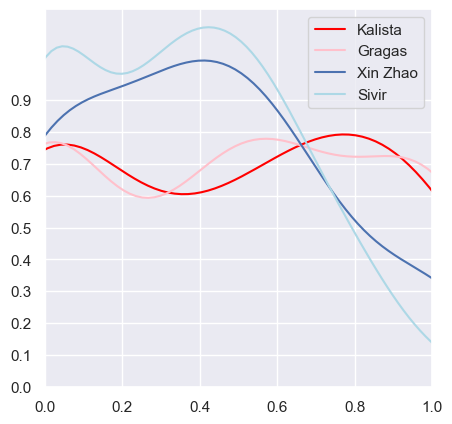

In [121]:
a = data[data.champion == 'Kalista'].groupby('player').mean().reset_index()[['player', 'result']].rename(columns={'result':'Kalista'})
b = data[data.champion == 'Xin Zhao'].groupby('player').mean().reset_index()[['player', 'result']].rename(columns={'result':'Xin Zhao'})
c = data[data.champion == 'Gragas'].groupby('player').mean().reset_index()[['player', 'result']].rename(columns={'result':'Gragas'})
d = data[data.champion == 'Sivir'].groupby('player').mean().reset_index()[['player', 'result']].rename(columns={'result':'Sivir'})
sns.set(rc={'figure.figsize':(5, 5)})
plt.xlim(0, 1)
plt.yticks(np.arange(0, 1, 0.1))
sns.kdeplot(a['Kalista'],color = 'red')
sns.kdeplot(c['Gragas'],color = 'pink')
sns.kdeplot(b['Xin Zhao'],color = 'b')
sns.kdeplot(d['Sivir'],color = 'lightblue')

Sorry for teams pick Xin Zhao and Sivir. They may lose their game at the begining.

The let's check the data for early game. 

At the early game, we generally suppose it as 10 minutes time point. 

I choose 3 feature for prediction:

Gold gain: Gold is the only source you can gain to buy items in game. The more gold gain, you may more suppress your opponents. The sources to gain gold are: 1. creep score (about 20). 2. Kills and assist(about 300 or more). 3. tower destroy(about 50 to 450). 4.Monster kill(important for Jungles, about 100). 5.other resource like items passive skills.

Xp: Determine the level of Champion. Higher level means more skills and hiher skill levels. And higher attributes of champions(attack, attack speed, armor and more).

creep score: In professional game, killing your opponents seems difficult. In most case, suppress your opponents is to suppress the creep score.


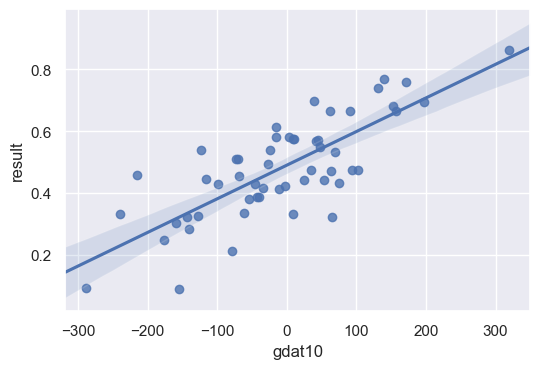

In [14]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'gdat10', y = 'result', data = team_data)

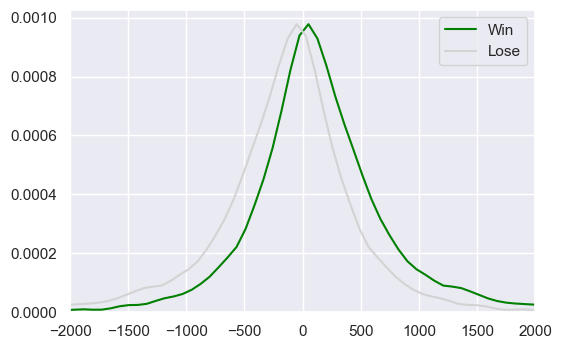

In [15]:
a = data[data.result == 1].rename(columns={'gdat10':'Win'})
b = data[data.result == 0].rename(columns={'gdat10':'Lose'})
plt.xlim(-2000, 2000)
sns.set(rc={'figure.figsize':(4, 4)})
sns.kdeplot(a['Win'],color = 'green')
sns.kdeplot(b['Lose'],color = 'lightgray')

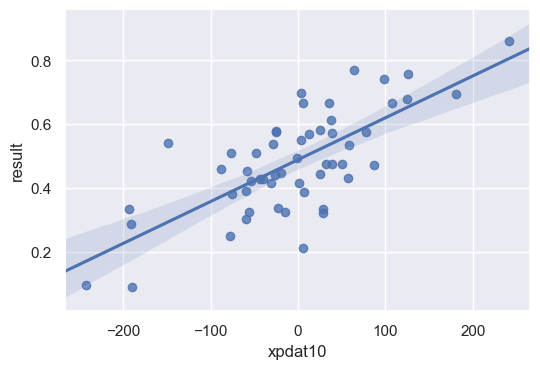

In [16]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'xpdat10', y = 'result', data = team_data)

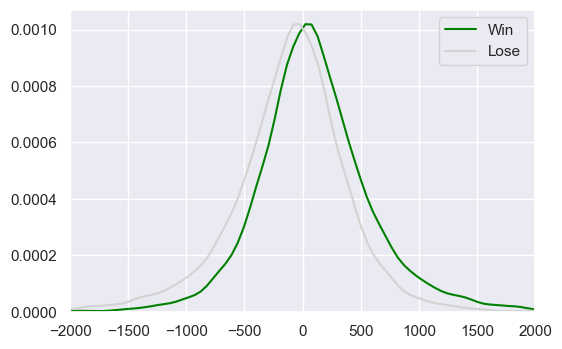

In [17]:
a = data[data.result == 1].rename(columns={'xpdat10':'Win'})
b = data[data.result == 0].rename(columns={'xpdat10':'Lose'})
plt.xlim(-2000, 2000)
sns.set(rc={'figure.figsize':(4, 4)})
sns.kdeplot(a['Win'],color = 'green')
sns.kdeplot(b['Lose'],color = 'lightgray')

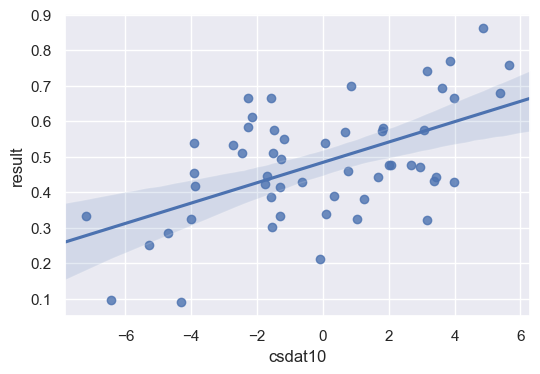

In [18]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'csdat10', y = 'result', data = team_data)

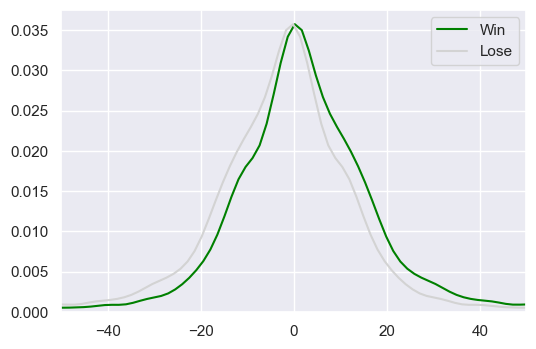

In [19]:
a = data[data.result == 1].rename(columns={'csdat10':'Win'})
b = data[data.result == 0].rename(columns={'csdat10':'Lose'})
plt.xlim(-50, 50)
sns.set(rc={'figure.figsize':(4, 4)})
sns.kdeplot(a['Win'],color = 'green')
sns.kdeplot(b['Lose'],color = 'lightgray')

Text(0, 0.5, 'win_rate')

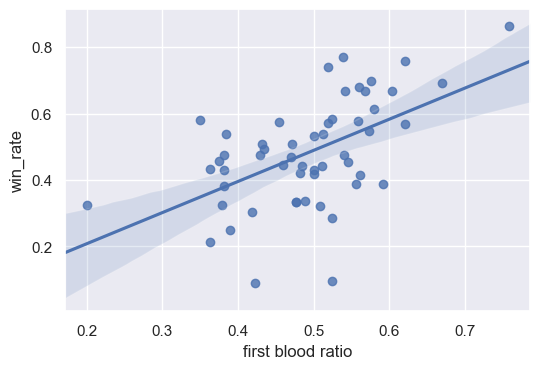

In [20]:
team_data1 = data[data.player == 'Team']
team_data1 = team_data1.groupby('team').mean().reset_index()
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'fb', y = 'result', data = team_data1)
plt.xlabel("first blood ratio")
plt.ylabel("win_rate")

The following is some important event for early game:

First blood: the one who first kill opponent. It would lead to huge suppress to opponent in professional game.

First tower: tower is the object to protect team's lane. Destroying tower will supress jungle and ward significantly.

First dragon: Dragon will provide positive buff to the whole team.


Text(0.5, 1.0, 'Wins vs first blood')

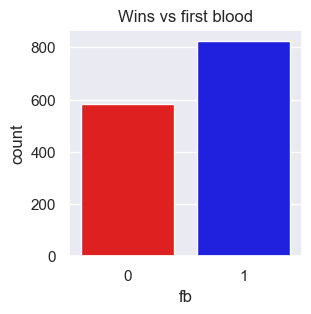

In [21]:
sns.set(rc={'figure.figsize':(3,3)})
games = data[data['player'] == 'Team']
games_win = games[games['fb'] == 1]
games_lose = games[games['fb'] == 0]
graph_data = pd.concat([games['fb'], games['result']], axis=1)
sns.countplot(graph_data[graph_data.result == 1]['fb'], palette=['red','blue'])
plt.title('Wins vs first blood')

Text(0, 0.5, 'win_rate')

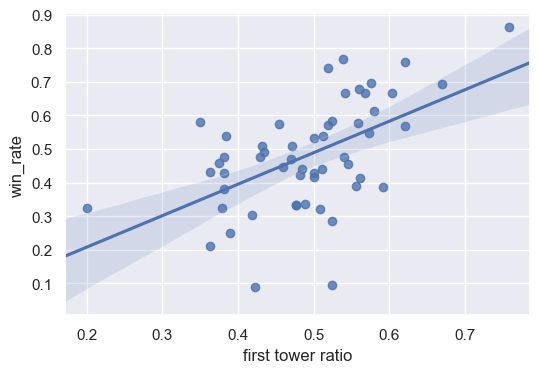

In [22]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'ft', y = 'result', data = team_data1)
plt.xlabel("first tower ratio")
plt.ylabel("win_rate")

Text(0.5, 1.0, 'Wins vs first tower')

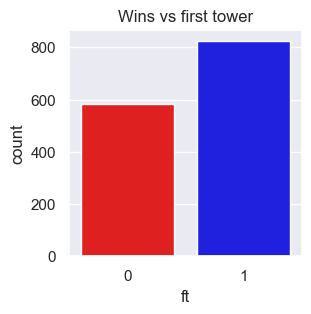

In [23]:
sns.set(rc={'figure.figsize':(3,3)})
games_win = games[games['ft'] == 1]
games_lose = games[games['ft'] == 0]
graph_data = pd.concat([games['ft'], games['result']], axis=1)
sns.countplot(graph_data[graph_data.result == 1]['ft'], palette=['red','blue'])
plt.title('Wins vs first tower')

Text(0, 0.5, 'win_rate')

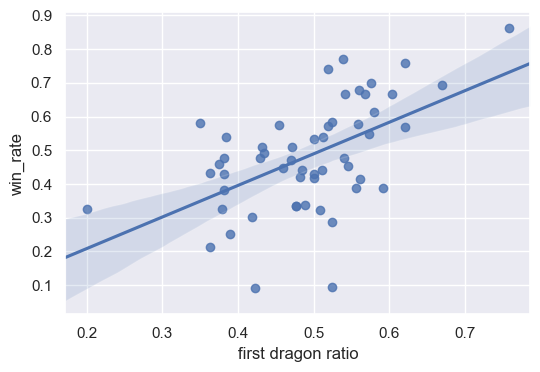

In [24]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.regplot(x = 'fd', y = 'result', data = team_data1)
plt.xlabel("first dragon ratio")
plt.ylabel("win_rate")

Text(0.5, 1.0, 'Wins vs first dragon')

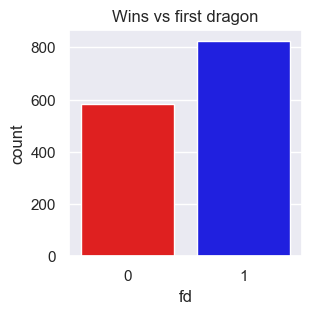

In [25]:
sns.set(rc={'figure.figsize':(3,3)})
games_win = games[games['fd'] == 1]
games_lose = games[games['fd'] == 0]
graph_data = pd.concat([games['fd'], games['result']], axis=1)
sns.countplot(graph_data[graph_data.result == 1]['fd'], palette=['red','blue'])
plt.title('Wins vs first dragon')

# Feature Selection
This is a process to generate Numpy arrays that suitable for training and testing.

The pre-match data include:

•	Side: blue side (1) or red side (0)

•	Team history result difference to opponents

•	Top picked champion history result difference

•	Jungle picked champion history result difference

•	Middle picked champion history result difference

•	ADC picked champion history result difference

•	Support picked champion history result difference

At 10 minutes time point, I create more features besides those features in pre-match for prediction:

•	Top, Jungle, Middle, ADC and Support gold gain difference at 10 minutes (5 features)

•	Top, Jungle, Middle, ADC and Support xp difference at 10 minutes (5 features)

•	Top, Jungle, Middle, ADC and Support creep score difference at 10 minutes (5 features)

•	First blood (first blood token (1), first blood victim (0))

•	First dragon (first dragon token (1), first dragon lost (0))

•	First tower (first tower token (1), first tower lost (0))


In [26]:
data0 = temp.drop(['url', 'league','split','date', 'week','game', 'patchno',
       'playerid','doubles', 'triples', 'quadras', 'pentas','ckpm'], axis=1)
data0['side'] = data0.apply(lambda x : 0 if x.side == 'Red' else 1,axis = 1)
pre_match = []
tenmin = []
for i in data0.gameid.unique():
    data1 = data0[data0.gameid == i]
    for j in [0,1]:
        team1 = data0[(data0.gameid == i)&(data0.side == j)].team.values[0]
        team2 = data0[(data0.gameid == i)&(data0.side != j)].team.values[0]
        pre_match_i = [data1[data1.side == j].result.values[0], j,team_data[team_data.team == team1].result.values[0] - team_data[team_data.team == team2].result.values[0]]
        tenmin_i = [data1[data1.side == j].result.values[0], j,team_data[team_data.team == team1].result.values[0] - team_data[team_data.team == team2].result.values[0]]
        a,b,c = 0,0,0
        for k in ['Top', 'Jungle', 'Middle', 'ADC', 'Support']:
            chm_dif = data1[(data1.side == j)&(data1.position == k)].c_r.values[0] - data1[(data1.side != j)&(data1.position == k)].c_r.values[0]
            pre_match_i.append(chm_dif)
            tenmin_i.append(chm_dif)
            ten_dif1 = data1[(data1.side == j)&(data1.position == k)].gdat10.values[0] - data1[(data1.side != j)&(data1.position == k)].gdat10.values[0]
            tenmin_i.append(ten_dif1)
            ten_dif2 = data1[(data1.side == j)&(data1.position == k)].xpdat10.values[0] - data1[(data1.side != j)&(data1.position == k)].xpdat10.values[0]
            tenmin_i.append(ten_dif2)
            ten_dif3 = data1[(data1.side == j)&(data1.position == k)].csdat10.values[0] - data1[(data1.side != j)&(data1.position == k)].csdat10.values[0]
            tenmin_i.append(ten_dif3)
            if data1[(data1.side == j)&(data1.position == k)].fb.values[0] > 0 and data1[(data1.side == j)&(data1.position == k)].fbtime.values[0] <= 10:
                a = 1
            if data1[(data1.side == j)&(data1.position == k)].ft.values[0] > 0 and data1[(data1.side == j)&(data1.position == k)].fttime.values[0] <= 10:
                b = 1
            if data1[(data1.side == j)&(data1.position == k)].fd.values[0] > 0 and data1[(data1.side == j)&(data1.position == k)].fdtime.values[0] <= 10:
                c = 1
            
        
        if a == 1:
            tenmin_i.append(1)
        else:
            tenmin_i.append(0)
        if b == 1:
            tenmin_i.append(1)
        else:
            tenmin_i.append(0)
        if c == 1:
            tenmin_i.append(1)
        else:
            tenmin_i.append(0)
        
        
        pre_match.append(pre_match_i)
        tenmin.append(tenmin_i)

In [27]:
pre_match = np.array(pre_match)

In [28]:
tenmin = np.array(tenmin)

In [29]:
tenmin[np.isnan(tenmin)] = 0 

# Modeling


# KNN

pre_match

I use select features based on their feature scores, which are the ANOVA F-values of each feature. Feature selection helps as it removes abundant features, reduces over-fitting, and makes model easier to interpret.

In [33]:
import scipy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [34]:
X_Prematch, X_TEST_Prematch,YY, Y_TEST = train_test_split(pre_match[:,1:], pre_match[:,0], test_size=0.2, random_state=1)

In [35]:
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(X_Prematch)
XX_pre_scaled=X_scaler.transform(X_Prematch)   
X_TEST_pre_scaled=X_scaler.transform(X_TEST_Prematch)

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
skf = StratifiedKFold(n_splits=5)
X=XX_pre_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

#here is to find the number of features and number of neighbors with best test accuracy.
features_settings=range(1,8)
neighbors_settings=range(1,50)

#generate the 0 np arrays to store the test accuracy
train_auc_3d_pre=np.zeros((5,7,50))
test_auc_3d_pre=np.zeros((5,7,50))

#Start to iteration
i=0 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for features in features_settings:
        
        feature_selector=SelectKBest(k=features)
        feature_selector.fit(X_train,y_train)
        X_train_rescaled_subset=feature_selector.transform(X_train)
        X_test_rescaled_subset=feature_selector.transform(X_test)
        k=0
        for n_neighbors in neighbors_settings:        
            # fit classifier
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train_rescaled_subset, y_train)
        
        
            # training
            dec_stat=clf.predict_proba(X_train_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_3d_pre[i,j,k]=roc_auc
            
            
            # testing
            dec_stat=clf.predict_proba(X_test_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_3d_pre[i,j,k]=roc_auc
            k=k+1
        j=j+1
    i=i+1

In [37]:
step1_train=np.mean(train_auc_3d_pre,axis=0)
step2_train=np.mean(step1_train,axis=1)

step1_test=np.mean(test_auc_3d_pre,axis=0)
step2_test=np.mean(step1_test,axis=1)

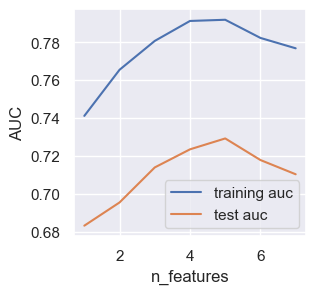

In [38]:
fig=plt.figure()
plt.plot(features_settings, step2_train, label="training auc")
plt.plot(features_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_features")
plt.legend()

Find the best number of features

In [39]:
np.argmax(step2_test) + 1

5

In [122]:
step1_train=np.mean(train_auc_3d_pre,axis=0)
step2_train=np.mean(step1_train,axis=0)

step1_test=np.mean(test_auc_3d_pre,axis=0)
step2_test=np.mean(step1_test,axis=0)

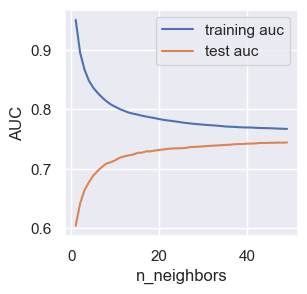

In [41]:

fig=plt.figure()
plt.plot(neighbors_settings, step2_train[0:49], label="training auc")
plt.plot(neighbors_settings, step2_test[0:49], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

Higher number of neighbors result in higher accuracy

Let's used these 2 number to fit and test

In [111]:
feature_selector=SelectKBest(k=5)
feature_selector.fit(XX_pre_scaled,YY)
X_selected=feature_selector.transform(XX_pre_scaled)#all data
clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_selected, YY)

X_test=feature_selector.transform(X_TEST_pre_scaled)

dec_stat=clf.predict_proba(X_test)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.7632165988567372

10 mins

Almost same to pre-match's process

In [43]:
XX_10, X_TEST_10,Y_10, Y_TEST_10 = train_test_split(tenmin[:,1:], tenmin[:,0], test_size=0.2, random_state=1)

In [44]:
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler()
X_scaler.fit(XX_10)
XX_10_scaled=X_scaler.transform(XX_10)   
X_TEST_10_scaled=X_scaler.transform(X_TEST_10)

In [45]:
skf = StratifiedKFold(n_splits=5)
X=XX_10_scaled
y=Y_10
splits_training_auc =[]
splits_test_auc =[]

features_settings=range(1,26)
neighbors_settings=range(1,50)

train_auc_3d_pre=np.zeros((5,25,50))
test_auc_3d_pre=np.zeros((5,25,50))
i=0 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for features in features_settings:
        
        feature_selector=SelectKBest(k=features)
        feature_selector.fit(X_train,y_train)
        X_train_rescaled_subset=feature_selector.transform(X_train)
        X_test_rescaled_subset=feature_selector.transform(X_test)
        k=0
        for n_neighbors in neighbors_settings:        
            # fit classifier
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train_rescaled_subset, y_train)
        
        
            # training
            dec_stat=clf.predict_proba(X_train_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_3d_pre[i,j,k]=roc_auc
           
            
            # testing
            dec_stat=clf.predict_proba(X_test_rescaled_subset)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_3d_pre[i,j,k]=roc_auc
            k=k+1
        j=j+1
    i=i+1

In [46]:
step1_train=np.mean(train_auc_3d_pre,axis=0)
step2_train=np.mean(step1_train,axis=1)

step1_test=np.mean(test_auc_3d_pre,axis=0)
step2_test=np.mean(step1_test,axis=1)

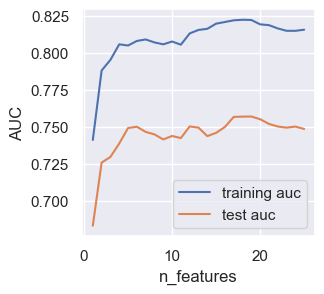

In [47]:
fig=plt.figure()
plt.plot(features_settings, step2_train, label="training auc")
plt.plot(features_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_features")
plt.legend()

In [48]:
np.argmax(step2_test) + 1

19

In [49]:
step1_train=np.mean(train_auc_3d_pre,axis=0)
step2_train=np.mean(step1_train,axis=0)
step1_test=np.mean(test_auc_3d_pre,axis=0)
step2_test=np.mean(step1_test,axis=0)

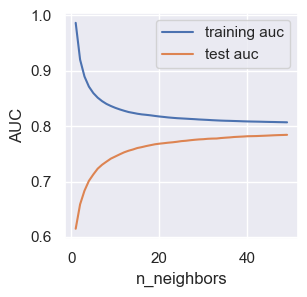

In [50]:
fig=plt.figure()
plt.plot(neighbors_settings, step2_train[0:49], label="training auc")
plt.plot(neighbors_settings, step2_test[0:49], label="test auc")
plt.ylabel("AUC")
plt.xlabel("n_neighbors")
plt.legend()

In [112]:
feature_selector=SelectKBest(k=19)
feature_selector.fit(XX_10_scaled,YY)
X_selected=feature_selector.transform(XX_10_scaled)
clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_selected, YY)

X_test=feature_selector.transform(X_TEST_10_scaled)

dec_stat=clf.predict_proba(X_test)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST_10,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.7942697440967337

# Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
skf = StratifiedKFold(n_splits=5)
X=XX_pre_scaled
y=YY
splits_training_auc =[]
splits_test_auc =[]

trees_settings=[50,75,100,125,150,175,200,225,250]
depth_settings=range(2,7)
train_auc_RF_pre=np.zeros((5,9,5))
test_auc_RF_pre=np.zeros((5,9,5))
i=0  
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for n_trees in trees_settings:   
        k=0
        for n_depth in depth_settings:
        
            # fit classifier
            clf = RandomForestClassifier(n_estimators=n_trees, max_features="auto",max_depth=n_depth,random_state=42)
            clf.fit(X_train, y_train)


            # training
            dec_stat=clf.predict_proba(X_train)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_RF_pre[i,j,k]=roc_auc
            #training_auc.append(roc_auc)

            # testing
            dec_stat=clf.predict_proba(X_test)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_RF_pre[i,j,k]=roc_auc
            k=k+1
        
        j=j+1
    i=i+1

In [54]:
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)
print(step2_test)

[0.77741643 0.7929417  0.81211231 0.83870693 0.86959119]
[0.74907252 0.75584672 0.75498605 0.75598685 0.7581482 ]


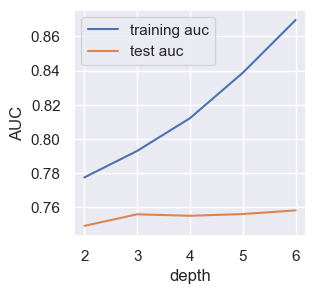

In [55]:
fig=plt.figure()
plt.plot(depth_settings, step2_train, label="training auc")
plt.plot(depth_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("depth")
plt.legend()

In [56]:
np.argmax(step2_test)+2

6

In [57]:
#determine number of features to keep
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)
print(step2_test)

[0.81709416 0.81718504 0.81780147 0.81814816 0.81865569 0.81867462
 0.81860047 0.81863302 0.81859078]
[0.75267176 0.75492407 0.75486905 0.75481984 0.75499897 0.75539541
 0.75509104 0.75514373 0.75535874]


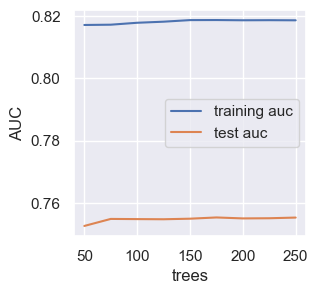

In [58]:
fig=plt.figure()
plt.plot(trees_settings, step2_train, label="training auc")
plt.plot(trees_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("trees")
plt.legend()


In [59]:
(np.argmax(step2_test)+2)*25

175

In [113]:

clf = RandomForestClassifier(n_estimators=175, max_features="auto",max_depth=6, random_state=42)
clf.fit(XX_pre_scaled, YY)

dec_stat=clf.predict_proba(X_TEST_pre_scaled)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.7748963838929237

In [61]:
clf.feature_importances_

array([0.01223474, 0.49509358, 0.10705859, 0.11452802, 0.10916886,
       0.09077415, 0.07114206])

As you can see, the team history win_rate did most attribute to the result of prediction.

10 mins

In [62]:
skf = StratifiedKFold(n_splits=5)
X=XX_10_scaled
y=Y_10
splits_training_auc =[]
splits_test_auc =[]

trees_settings=[50,75,100,125,150,175,200,225,250]
depth_settings=range(2,26)
train_auc_RF_pre=np.zeros((5,9,24))
test_auc_RF_pre=np.zeros((5,9,24))
i=0 #use i,j,k for indexting so that I can store auc value in corresponding position for each iteration 
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    j=0
    for n_trees in trees_settings:   
        k=0
        for n_depth in depth_settings:
        
            # fit classifier
            clf = RandomForestClassifier(n_estimators=n_trees, max_features="auto",max_depth=n_depth,random_state=42)
            clf.fit(X_train, y_train)


            # training
            dec_stat=clf.predict_proba(X_train)[:,0]
            fpr, tpr, _ = roc_curve(y_train,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            train_auc_RF_pre[i,j,k]=roc_auc
            #training_auc.append(roc_auc)

            # testing
            dec_stat=clf.predict_proba(X_test)[:,0]
            fpr, tpr, _ = roc_curve(y_test,dec_stat,pos_label=0)
            roc_auc = auc(fpr, tpr)
            test_auc_RF_pre[i,j,k]=roc_auc
            k=k+1
        
        j=j+1
    i=i+1

In [63]:
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=0)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=0)
print(step2_test)

[0.81315471 0.8370634  0.86404516 0.89729644 0.93185026 0.96278918
 0.98418684 0.99460734 0.99878541 0.99977975 0.99997134 0.99999796
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
[0.78210669 0.79089889 0.79673106 0.79976991 0.80086993 0.8013346
 0.8005075  0.80083413 0.79756757 0.79785278 0.79795469 0.79701823
 0.7935234  0.79591714 0.79476636 0.79534312 0.79680995 0.79654543
 0.79662341 0.79656984 0.79671148 0.79677863 0.79685888 0.79693251]


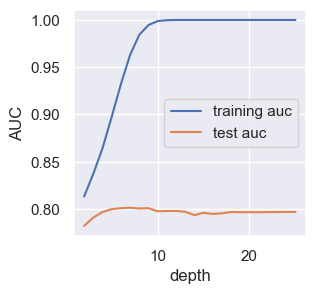

In [64]:
fig=plt.figure()
plt.plot(depth_settings, step2_train, label="training auc")
plt.plot(depth_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("depth")
plt.legend()

In [65]:
np.argmax(step2_test)+2

7

In [66]:
step1_train=np.mean(train_auc_RF_pre,axis=0)#first average across cross-validation
step2_train=np.mean(step1_train,axis=1)#now is depth
print(step2_train)

step1_test=np.mean(test_auc_RF_pre,axis=0)#first average across cross-validation
step2_test=np.mean(step1_test,axis=1)
print(step2_test)

[0.96966851 0.97010812 0.97017481 0.9701666  0.9701372  0.97022755
 0.97027581 0.97028049 0.97028382]
[0.79080756 0.79429649 0.79640284 0.79658462 0.79768448 0.79814862
 0.79817658 0.79834412 0.7983645 ]


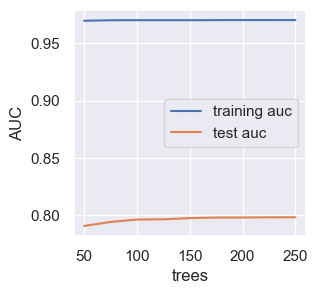

In [67]:
fig=plt.figure()
plt.plot(trees_settings, step2_train, label="training auc")
plt.plot(trees_settings, step2_test, label="test auc")
plt.ylabel("AUC")
plt.xlabel("trees")
plt.legend()

In [68]:
(np.argmax(step2_test)+2)*25

250

In [114]:
clf = RandomForestClassifier(n_estimators=250, max_features="auto",max_depth=6, random_state=42)
clf.fit(XX_10_scaled, YY)

dec_stat=clf.predict_proba(X_TEST_10_scaled)[:,0]
fpr, tpr, _ = roc_curve(Y_TEST_10,dec_stat,pos_label=0)
roc_auc = auc(fpr, tpr)
roc_auc

0.8136811285600214

# MLP

pre-match

In [70]:
import tensorflow as tf

In [71]:
XX_pre_scaled.shape

(2246, 7)

In [72]:
skf = StratifiedKFold(n_splits=5)
X=XX_pre_scaled
y=np.array([YY, -(YY-1)]).T
y_test=np.array([Y_TEST, -(Y_TEST-1)]).T
splits_training_auc =[]
splits_test_auc =[]

lr_settings=[0.5,0.1,0.05,0.01,0.005]
n1_settings=[7,14,21,28,35,42]
n2_settings=[7,14,21,28,35,42]

test_accuracy_3d=np.zeros((5,6,6))

In [73]:
import time
import sys
X_train, X_test, y_train, y_test = XX_pre_scaled, X_TEST_pre_scaled, y, y_test
training_epochs = 100
batch_size = 32
n_input = 7 
n_classes = 2 
j=0
for lr in lr_settings:
    learning_rate = lr
    k=0
    for n1 in n1_settings:
        n_hidden_1=n1
        l=0
        for n2 in n2_settings:
            n_hidden_2 = n2
            x = tf.placeholder("float", [None, n_input])
            y = tf.placeholder("float", [None, n_classes])

            def multilayer_perceptron(x, weights, biases):
                layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
                layer_1 = tf.nn.relu(layer_1)
                    
                layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
                layer_2 = tf.nn.relu(layer_2)
                    
                out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
                return out_layer

            weights = {
                    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
                    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
                }

            biases = {
                    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
                    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_classes]))
                }

            pred = multilayer_perceptron(x, weights, biases)


            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                sess.run(init)
                    
                for epoch in range(training_epochs):
                    avg_cost = 0.
                    total_batch = int(len(X)/batch_size)
                    X_batches = np.array_split(X_train, total_batch)
                    Y_batches = np.array_split(y_train, total_batch)
                        
                    for i in range(total_batch):
                        batch_x, batch_y = X_batches[i], Y_batches[i]
                        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                        avg_cost += c / total_batch
                        
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
               
                print('\r {} % has been done'.format(round((l + k*6 + j*6*6)/180*100),2), end='')
                
                
                test_accuracy_3d[j,k,l]=accuracy.eval({x: X_test, y: y_test})
                    
            l=l+1
        k=k+1
    j=j+1


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

 99 % has been done

In [74]:
full_test=test_accuracy_3d

In [104]:
lr = lr_settings[np.argmax(np.mean(full_test,axis=(1,2)))]
n1 = n1_settings[np.argmax(np.mean(full_test,axis=(0,2)))]
n2 = n2_settings[np.argmax(np.mean(full_test,axis=(0,1)))]

Therefore, learning rate = 0.1, n1 = 7, n2 = 7

In [115]:
y=np.array([YY, -(YY-1)]).T
y_test=np.array([Y_TEST, -(Y_TEST-1)]).T
X_train, X_test, y_train, y_test = XX_pre_scaled, X_TEST_pre_scaled, y, y_test
training_epochs = 100
batch_size = 32
n_input = 7 
n_classes = 2 


learning_rate = 0.1
n_hidden_1=7
n_hidden_2 = 7
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
                    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
                    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
                }

biases = {
                    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
                    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_classes]))
                }
pred = multilayer_perceptron(x, weights, biases)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X)/batch_size)
        X_batches = np.array_split(X_train, total_batch)
        Y_batches = np.array_split(y_train, total_batch)
                        
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
                        
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    test_accuracy=accuracy.eval({x: X_test, y: y_test})


In [116]:
test_accuracy

0.702847

10 min

In [95]:
skf = StratifiedKFold(n_splits=5)
X=XX_10_scaled
y=np.array([Y_10, -(Y_10-1)]).T
y_test=np.array([Y_TEST_10, -(Y_TEST_10-1)]).T
splits_training_auc =[]
splits_test_auc =[]

lr_settings=[0.5,0.1,0.05,0.01,0.005]
n1_settings=[25,50,75,100,125,150]
n2_settings=[25,50,75,100,125,150]

test_accuracy_3d=np.zeros((5,6,6))

In [96]:
X_train, X_test, y_train, y_test = XX_10_scaled, X_TEST_10_scaled, y, y_test
training_epochs = 100
batch_size = 32
n_input = 25 
n_classes = 2 
j=0
for lr in lr_settings:
    learning_rate = lr
    k=0
    for n1 in n1_settings:
        n_hidden_1=n1
        l=0
        for n2 in n2_settings:
            n_hidden_2 = n2
            x = tf.placeholder("float", [None, n_input])
            y = tf.placeholder("float", [None, n_classes])

            def multilayer_perceptron(x, weights, biases):
                layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
                layer_1 = tf.nn.relu(layer_1)
                    
                layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
                layer_2 = tf.nn.relu(layer_2)
                    
                out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
                return out_layer

            weights = {
                    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
                    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
                }

            biases = {
                    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
                    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_classes]))
                }

            pred = multilayer_perceptron(x, weights, biases)


            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                sess.run(init)
                    
                for epoch in range(training_epochs):
                    avg_cost = 0.
                    total_batch = int(len(X)/batch_size)
                    X_batches = np.array_split(X_train, total_batch)
                    Y_batches = np.array_split(y_train, total_batch)
                        
                    for i in range(total_batch):
                        batch_x, batch_y = X_batches[i], Y_batches[i]
                        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                        avg_cost += c / total_batch
                        
                correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

                accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                
                print('\r {} % has been done'.format(round((l + k*6 + j*6*6)/179*100),2), end='')
                
                test_accuracy_3d[j,k,l]=accuracy.eval({x: X_test, y: y_test})
                    
            l=l+1
        k=k+1
    j=j+1


 100 % has been done

In [108]:
full_test=test_accuracy_3d

In [106]:
lr = lr_settings[np.argmax(np.mean(full_test,axis=(1,2)))]
n1 = n1_settings[np.argmax(np.mean(full_test,axis=(0,2)))]
n2 = n2_settings[np.argmax(np.mean(full_test,axis=(0,1)))]

143

In [100]:
lr, n1, n2

(0.01, 25, 125)

In [117]:
y=np.array([Y_10, -(Y_10-1)]).T
y_test=np.array([Y_TEST_10, -(Y_TEST_10-1)]).T
X_train, X_test, y_train, y_test = XX_10_scaled, X_TEST_10_scaled, y, y_test
training_epochs = 10
batch_size = 32
n_input = 25 
n_classes = 2 


learning_rate = 0.01
n_hidden_1=25
n_hidden_2 = 125
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
                    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
                    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
                }

biases = {
                    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
                    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
                    'out': tf.Variable(tf.random_normal([n_classes]))
                }
pred = multilayer_perceptron(x, weights, biases)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X)/batch_size)
        X_batches = np.array_split(X_train, total_batch)
        Y_batches = np.array_split(y_train, total_batch)
                        
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
                        
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    test_accuracy=accuracy.eval({x: X_test, y: y_test})


In [119]:
test_accuracy

0.67793596